<font color='red'>**In this notebook, all three embedding models are trained/used to generate neighbourhood specific review embeddings**</font>

# Imports and Global Variables


In [0]:
!pip install pyshp
import pickle, math, random, shapefile, shapely
from shapely.geometry import Polygon, Point

     |████████████████████████████████| 225kB 3.4MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32609 sha256=7adc4b631711eabe923efd9535556ee2b2b23e6f73fb3a122a1e6da301225f51
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ast import literal_eval
from collections import defaultdict
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from scipy import sparse
import spacy

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import string
import random
import torch.utils.data as Data
from torchtext.data import Field, BucketIterator
from torchtext import data

from collections import OrderedDict
import locale
from locale import atof, atoi
locale.setlocale(locale.LC_NUMERIC, '')

'en_US.UTF-8'

In [0]:
!pip install pytorch-ignite

In [0]:
from ignite.handlers import ModelCheckpoint, EarlyStopping, TerminateOnNan
from ignite.engine import Engine, Events
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar

In [0]:
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
use_idf = True
max_features = 2**10
pca_components = 2**4
ngram_range = (1,2)
min_df = 100
DRIVE_PATH = Path('/content/drive/My Drive/Thesis2019/')
BUSINESS_DATA_PATH = Path('businesses_final.csv')
NEIGHBOURHOOD_SHAPEFILE_PATH = "neighbourhoods_wgs84/NEIGHBORHOODS_WGS84"
REVIEWS_PATH = ('reviews.csv')
use_cuda = True
years = [2011, 2016]

EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.3

# Data Cleaning and Preprocessing

## TF-IDF Autoencoder

### For Autoencoder training

The datasets loaded in this section are pre-cleaned as described under section 4.2. in the report. 

Reference: https://github.com/alexwolson/uem_projects/blob/master/notebooks/Autoencoders/MAIN_LSA_Neighbourhoods.ipynb

In [0]:
bf_text = pd.read_csv(Path.joinpath(DATA_DIR,'business_text_stripped_all.csv')).dropna()
uf_text = pd.read_csv(Path.joinpath(DATA_DIR,'user_text_stripped_all.csv')).dropna()
nf_text = pd.read_csv(Path.joinpath(DATA_DIR,'neighborhood_text_stripped_all.csv')).dropna()
rf_text = pd.read_csv(Path.joinpath(DATA_DIR,'text_stripped_all.csv')).dropna()

In [0]:
alldocs = list(bf_text['text'].values) + list(uf_text['text'].values) + list(nf_text['text'].values) + list(rf_text['text'].values)

bids = list(bf_text['business'].values)
uids = list(uf_text['user'].values)
nids = list(nf_text['neighborhood'].values)

In [0]:
# Build Count Vector
p = DRIVE_PATH.joinpath('models/vectorizer.pickle')
if p.exists():
    with open(p,'rb') as f:
        vectorizer = pickle.load(f)
    vector_words = vectorizer.transform(alldocs)
else:
    vectorizer = CountVectorizer(strip_accents='ascii', 
                                 stop_words='english', 
                                 ngram_range=ngram_range,
                                 min_df=min_df,
                                 max_features=max_features
                                )
    vector_words = vectorizer.fit_transform(alldocs)
    with open(str(DRIVE_PATH.joinpath('models/vectorizer.pickle')),'wb') as f:
        pickle.dump(vectorizer,f)
words = vectorizer.get_feature_names()

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [0]:
# Store feature/word names
with open(DRIVE_PATH.joinpath('models/words.out'), "w") as txt_file:
    for word in words:
        txt_file.write(word + "\n")

In [0]:
# Build TF-IDF Vector
if use_idf:
    p = DRIVE_PATH.joinpath('models/tfidftransformer.pickle')
    if p.exists():
        with open(p,'rb') as f:
            transformer = pickle.load(f)
    else:
        transformer = TfidfTransformer(use_idf=True)
        transformer = transformer.fit(vector_words)
        with open(p,'wb') as f:
            pickle.dump(transformer,f)

transform = lambda x: normalize(
    transformer.transform(
        vectorizer.transform(
            x.text.values
        )
    ),
    norm='l1',
    axis=1)

In [0]:
bf_vecs = transform(bf_text)
uf_vecs = transform(uf_text)
nf_vecs = transform(nf_text)
rf_vecs = transform(rf_text)

In [0]:
# Create dataset wrapper for PyTorch
class ReviewsVector(Data.Dataset):
    """Reviews Vector dataset."""

    def __init__(self, data):
        """
        Args: 
          data

        """
        self.shape = data.shape
        self.data = torch.tensor(data).type(torch.FloatTensor)
        if use_cuda and torch.cuda.is_available():
          self.data = self.data.cuda()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [0]:
train_vals = sparse.vstack([rf_vecs, bf_vecs, uf_vecs]).todense()
neighborhoods_real = np.array(nf_vecs.todense())
train_data = ReviewsVector(train_vals)
val_data = ReviewsVector(neighborhoods_real)

In [0]:
del train_vals
del neighborhoods_real

### For census change prediction

For census change prediction, the reviews need to be separated by years, and aggregated by neighbourhoods. All reviews in businesses that fall under a neighbourhood's geographical region will be concatenated together.  

In [0]:
# select reviews in English only, and store only necessary data
reviews = pd.read_csv(DRIVE_PATH.joinpath(REVIEWS_PATH))
cleaned_reviews = reviews[reviews['review_language']=='en'][['business_id', 'review_text', 'Year']]
cleaned_reviews.to_csv(DRIVE_PATH.joinpath('cleaned_reviews.csv'), index=False)

del reviews
del cleaned_reviews

In [0]:
# function for concatenating reviews
def concat_reviews(x):
  try:
    return '\n\n'.join(x)
  except:
    return ''

In [0]:
# Concatentate reviews first by business and year
alldocs = {}
busids = {}
for year in years:
  reviews_in_year = reviews[reviews['Year']==year]
  b_reviews = reviews_in_year[['business_id', 'review_text']].groupby('business_id')['review_text'].apply(concat_reviews).reset_index()
  b_reviews.drop_duplicates(inplace=True)
  alldocs[year] = list(b_reviews['review_text'].values)
  busids[year] = list(b_reviews['business_id'].values)

In [0]:
# Put businesses into their corresponding neighbourhoods
# Reference: https://github.com/alexwolson/uem_projects/blob/master/notebooks/Autoencoders/MAIN_LSA_Neighbourhoods.ipynb
bf = pd.read_csv(DRIVE_PATH.joinpath(BUSINESS_DATA_PATH))
sf = shapefile.Reader(str(DRIVE_PATH)+'/'+NEIGHBOURHOOD_SHAPEFILE_PATH)
d = {}
for shape in sf.iterShapeRecords():
    d[shape.record.AREA_NAME] = Polygon(shape.shape.points)

pcabids = []
    
n2bid = defaultdict(list)

for bid,loc in tqdm(bf[['id','coordinates']].values):
    loc = literal_eval(loc)
    if loc['longitude'] is not None and loc['latitude'] is not None:
        p = Point(loc['longitude'],loc['latitude'])
        for k,v in d.items():
            if v.contains(p):
                n2bid[k].append(bid)

100%|██████████| 32123/32123 [00:29<00:00, 1091.61it/s]


In [0]:
# Create neighbourhood representation for each year
all_neighbourhoodcounts = {}

for year in years:
  neighbourhoodcounts = {}
  docs = alldocs[year]
  busid = busids[year]
  for k,v in tqdm(n2bid.items(),total=len(n2bid.keys())):
      total = ''
      for bid in v:
          if bid in busid:
              total += docs[busid.index(bid)] + '\n'
      neighbourhoodcounts[k] = total

  all_neighbourhoodcounts[year] = neighbourhoodcounts

In [0]:
all_n_reviews = {}
for year in years:
    all_n_reviews[year] = pd.DataFrame(pd.Series(all_neighbourhoodcounts[year])).sort_index()

In [0]:
Xs = {}

for year in years:
  Xs[year] = transform(all_n_reviews[year])

In [0]:
reviews_all = {}

for year in years:
  reviews_all[year] = pd.DataFrame(Xs[year].todense()).T
  reviews_all[year].to_csv(str(DRIVE_PATH)+'/neighbourhood_reviews_'+str(year)+'.csv')

## ELMO

### For Census change prediction
Different from the data cleaning for TF-IDF Autoencoder, for computational efficiency, business reviews are not concatenated to form one single string, but put into a list of strings. Each review in the list of strings will be embedded with ELMO first, then, their averages will be taken.  

In [0]:
alldocs_lists = {}
for year in [2011, 2016]:
  alldocs_lists[year] = [x.split('\n\n') for x in alldocs[year]]

In [0]:
all_neighbourhoodcounts = {}

for year in [2011, 2016]:
  neighbourhoodcounts = {}
  docs = alldocs_lists[year]
  busid = busids[year]
  for k,v in tqdm(n2bid.items(),total=len(n2bid.keys())):
      total = []
      for bid in v:
          if bid in busid:
              total.extend(docs[busid.index(bid)])
      neighbourhoodcounts[k] = total

  all_neighbourhoodcounts[year] = neighbourhoodcounts

# Model Training

## TF-IDF Autoencoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, sizes):
        super(Encoder, self).__init__()
                
        layers_en = OrderedDict()       
        for i in range(len(sizes)-1):
            layer_name = 'linear{}'.format(i+1)
            act_name = 'activation{}'.format(i+1)
            layers_en[layer_name] = nn.Linear(sizes[i], sizes[i+1])
            if i==0:
                nn.init.xavier_uniform_(layers_en[layer_name].weight)
            layers_en[act_name] = nn.Tanh()
        
        self.encoder = nn.Sequential(layers_en)

    def forward(self, x):
        return self.encoder(x) 
    
class Decoder(nn.Module):
    def __init__(self, sizes):
        super(Decoder, self).__init__()
        
        sizes = sizes[::-1]
        
        layers_de = OrderedDict()
        for i in range(len(sizes)-2):
            layer_name = 'linear{}'.format(i+1)
            act_name = 'activation{}'.format(i+1)
            layers_de[layer_name] = nn.Linear(sizes[i], sizes[i+1])
            layers_de[act_name] = nn.Tanh()

        layers_de['linear{}'.format(len(sizes)-1)] = nn.Linear(sizes[-2], sizes[-1])
        layers_de['sigmoid'] = nn.Sigmoid()
        self.decoder = nn.Sequential(layers_de)

    def forward(self, encoded):
        return self.decoder(encoded) 

In [0]:
def criterion(data, decoded):
    cossim_loss = nn.CosineEmbeddingLoss(reduction='sum') # Pytorch built-in Cosine similarity for calculating loss 
    y = torch.tensor(np.ones((data.shape[0], 1)), dtype=torch.float).cuda()
    if use_cuda and torch.cuda.is_available():
      y = y.cuda()
    loss = cossim_loss(data, decoded, y)
    return loss


In [0]:
def training(encoder, decoder, batch_size):
  train_losses = []
  val_losses = []

  optimizer_en = optim.Adam(encoder.parameters(), lr=lr)
  scheduler_en = optim.lr_scheduler.ReduceLROnPlateau(optimizer_en, 'min', patience=patience, min_lr=min_lr, factor=0.1)
  optimizer_de = optim.Adam(decoder.parameters(), lr=lr)
  scheduler_de = optim.lr_scheduler.ReduceLROnPlateau(optimizer_de, 'min', patience=patience, min_lr=min_lr, factor=0.1)

  def process_function(engine, batch):
    encoder.train()
    decoder.train()
    optimizer_en.zero_grad()
    optimizer_de.zero_grad()
    encoded = encoder(batch)
    decoded = decoder(encoded)
    loss = criterion(decoded, batch)
    loss.backward()

    optimizer_en.step()
    optimizer_de.step()
    return loss.item()
  

  def eval_function(engine, batch):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        encoded = encoder(batch)
        decoded = decoder(encoded)
        return decoded, batch
  
  trainer = Engine(process_function)
  train_evaluator = Engine(eval_function)
  validation_evaluator = Engine(eval_function)

  metric = Loss(criterion)
  metric.attach(train_evaluator, 'loss')
  metric.attach(validation_evaluator, 'loss')

  pbar = ProgressBar(persist=True, bar_format="")
  pbar.attach(trainer, ['loss'])

  @trainer.on(Events.EPOCH_COMPLETED)

  def log_training_results(engine):
      train_evaluator.run(train_iterator)
      metrics = train_evaluator.state.metrics
      avg_loss = metrics['loss']    
      
      train_losses.append(avg_loss)

      pbar.log_message(
          "Training Results - Epoch: {}  Avg loss: {:.4f}"
          .format(engine.state.epoch, avg_loss))
      
  def log_validation_results(engine):
      validation_evaluator.run(valid_iterator)
      metrics = validation_evaluator.state.metrics
      avg_loss = metrics['loss']

      val_losses.append(avg_loss)

      pbar.log_message(
          "Validation Results - Epoch: {}  Avg loss: {:.4f}"
          .format(engine.state.epoch, avg_loss))
      pbar.n = pbar.last_print_n = 0

  trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

  # Reduce on Plateau
  def average_loss(engine):
    print("Current lr: {}".format(optimizer_de.param_groups[0]['lr']))
    average_loss = engine.state.metrics['loss']
    scheduler_en.step(average_loss)
    scheduler_de.step(average_loss)

  validation_evaluator.add_event_handler(Events.COMPLETED, average_loss)
  
  # Early Stopping
  def score_function(engine):
      val_loss = engine.state.metrics['loss']
      return -val_loss

  handler = EarlyStopping(patience=100, score_function=score_function, trainer=trainer)
  validation_evaluator.add_event_handler(Events.COMPLETED, handler)

  # Model Checkpoint
  checkpointer = ModelCheckpoint(str(DRIVE_PATH.joinpath('models')), 'review', save_interval=10, n_saved=1, create_dir=False, save_as_state_dict=True, require_empty=False)
  trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'encoder': encoder, 'decoder': decoder})

  train_iterator = Data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
  valid_iterator = Data.DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=False)

  trainer.run(train_iterator, max_epochs=500)

  return train_losses, val_losses

In [0]:
lr = 0.001
patience = 20
min_lr = 0.00001

In [0]:
sizes_r = [max_features, 2**10, 2**8, pca_components]
encoder = Encoder(sizes_r)
decoder = Decoder(sizes_r)

if use_cuda and torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

In [0]:
encoder

Encoder(
  (encoder): Sequential(
    (linear1): Linear(in_features=1024, out_features=1024, bias=True)
    (activation1): Tanh()
    (linear2): Linear(in_features=1024, out_features=256, bias=True)
    (activation2): Tanh()
    (linear3): Linear(in_features=256, out_features=16, bias=True)
    (activation3): Tanh()
  )
)

In [0]:
decoder

Decoder(
  (decoder): Sequential(
    (linear1): Linear(in_features=16, out_features=256, bias=True)
    (activation1): Tanh()
    (linear2): Linear(in_features=256, out_features=1024, bias=True)
    (activation2): Tanh()
    (linear3): Linear(in_features=1024, out_features=1024, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [0]:
train_losses, val_losses = training(encoder, decoder, train_data.data.shape[0]//100)

Text(0, 0.5, 'Loss')

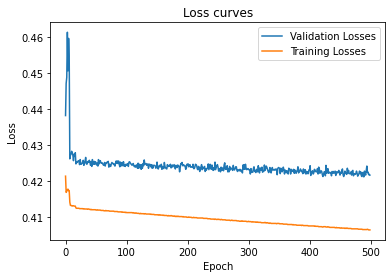

In [0]:
plt.plot(np.arange(len(val_losses)), val_losses, np.arange((len(train_losses))), train_losses)
plt.legend(['Validation Losses', 'Training Losses'])
plt.title('Loss curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')

## ELMO

In [0]:
import tensorflow_hub as hub
import tensorflow as tf

elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [0]:
def get_elmo_embedding(x):
  # print(x)
  batches = [x[i:i+batch_size] for i in range(0, len(x), batch_size)]

  all_embeddings = np.zeros(1024)
  count = 0
  with sess.as_default():
    for batch in batches:
      embeddings = elmo(batch, signature="default", as_dict=True)["elmo"]
      embeddings = tf.reduce_mean(embeddings, (0, 1)).eval()
      all_embeddings = all_embeddings + embeddings
      count += 1

  return all_embeddings/count

In [0]:
batch_size = 100

In [0]:
for year in years:
  for n in all_neighbourhoodcounts[year]:  
    print(n)

    if flag == 1:
      emb = get_elmo_embedding(all_neighbourhoodcounts[year][n])
      name = str(DRIVE_PATH.joinpath("elmo/elmo{}_{}".format(year, n.replace("/", ""))))
      np.save(name, emb)

In [0]:
elmo_reviews_2011 = {}
elmo_reviews_2016 = {}

for n in all_neighbourhoodcounts[2011]:  
    name = str(DRIVE_PATH.joinpath("elmo/elmo2011_{}".format(n.replace("/", ""))))+'.npy'
    elmo_reviews_2011[n] = np.load(name)

for n in all_neighbourhoodcounts[2016]:  
    name = str(DRIVE_PATH.joinpath("elmo/elmo2016_{}".format(n.replace("/", ""))))+'.npy'
    elmo_reviews_2016[n] = np.load(name)

reviews_2011 = pd.DataFrame(elmo_reviews_2011).T
reviews_2011.sort_index(inplace=True)
reviews_2011.to_csv(DRIVE_PATH.joinpath('elmo_reviews_2011.csv'))

reviews_2016 = pd.DataFrame(elmo_reviews_2016).T
reviews_2016.sort_index(inplace=True)
reviews_2016.to_csv(DRIVE_PATH.joinpath('elmo_reviews_2016.csv'))